In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

['ID', 'inputs', 'outputs', 'T/K', 'sigma/kbT', 'nDonors']
max==0.6430139290240099, min==0.4241939833613531
temp==[77.]
sigma==[0.]
nDonors==[3]
[[ 0.         -1.26826166  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.         -1.0458624   4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.          0.434396    4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.         -0.11119457  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.         -0.96667179  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.          0.75420343  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.          1.23360887  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.         -1.27924534  4.67353704  0.45973952  4.7668572   3.25121352
   4.10936069  4.99899791]
 [ 0.          0.60658067  4.67353704  0.459739

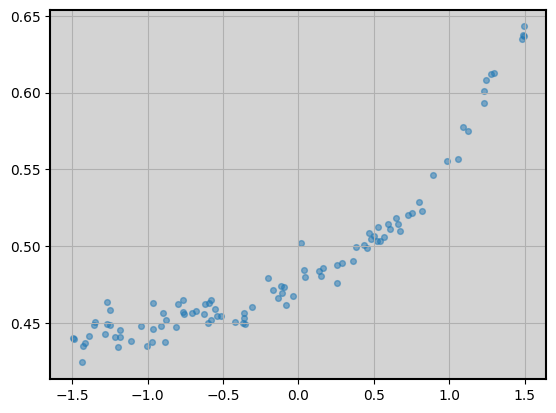

In [24]:
batch_0 = np.load("currentData/batch_0.npz")
batch_1 = np.load("currentData/batch_4.npz")
print(batch_0.files)
inputs = batch_1["inputs"]
outputs = batch_1["outputs"]

max_output = outputs.max()
min_output = outputs.min()

print(f"max=={max_output}, min=={min_output}")
print(f"temp=={batch_1['T/K']}\n"
      f"sigma=={batch_1['sigma/kbT']}\n"
      f"nDonors=={batch_1['nDonors']}")

print(inputs[:10, :])

fig, ax = plt.subplots()

""" ax.scatter(
    batch_0["inputs"][:, 1], 
    batch_0["outputs"],
    alpha=0.5,
    s=17) """

ax.scatter(
    batch_1["inputs"][:, 1], 
    batch_1["outputs"],
    alpha=0.5,
    s=17)

ax.grid(True)
ax.spines[["top", "bottom", "left", "right"]].set_linewidth(1.5)
ax.set_facecolor("lightgrey")

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,
                 inputs: np.array,
                 outputs: np.array) -> None:
        
        self.transform = None

In [13]:
class NeuralNet(torch.nn.Module):
    def __init__(self,
                 paramDict: dict) -> None:
        super().__init__()
        """
        Network pars
        """
        self.latent_dim = paramDict['latent_dim']
        self.input_dim = paramDict['input_dim']
        self.output_dim = paramDict['output_dim']
        
        self.num_layers = paramDict['num_layers']
        
        self.epochs = paramDict['epochs']
        self.lr = paramDict['lr']

        self.training_loss = []
        self.test_loss = []

        self.network = self._build_model()

        self.loss_fn = torch.nn.MSELoss()


    def _build_model(self) -> nn.Sequential:
        
        network_layers = []
        network_layers += [nn.Linear(self.input_dim, self.latent_dim, bias=True)]
        network_layers += [nn.ReLU]

        for _layer in range(self.num_layers):
            network_layers+=[nn.Linear(self.latent_dim, self.latent_dim, bias=True)]
            network_layers+=[nn.ReLU]
        
        network_layers += [nn.Linear(self.latent_dim, self.output_dim, bias=True)]
        network_layers += [nn.Sigmoid()]

        network_block = nn.Sequential(*network_layers)

        return network_block
        
    def forward(self, x) -> torch.Tensor:

        x = self.network(x)

        return x
    
    def calculate_loss(self, y, y_hat):

        loss = self.loss_fn(y, y_hat)

        return loss
        
    
def train(neural_net: torch.nn.Module,
          optimizer: torch.optim,
          learning_rate: float,
          epochs: int,
          dataloader: DataLoader
          ):
    
    losses = []

    for _epoch in range(epochs):
        loss_on_epoch = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x, y = batch

            y_hat = neural_net(x)

            loss = neural_net.calculate_loss(y, y_hat)

            loss.backward()

            optimizer.step()

            loss_on_epoch += loss.item() / batch.size()
        
        losses.append(loss_on_epoch)

    return losses
    


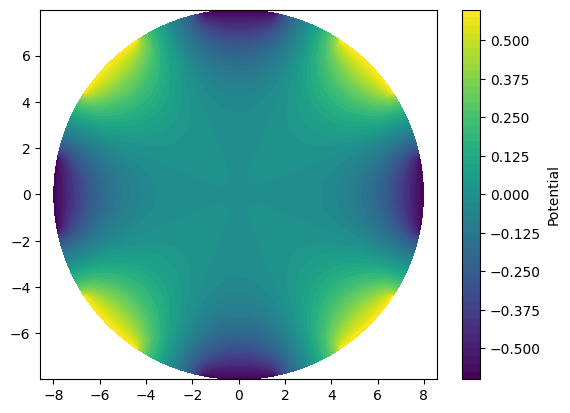

In [12]:
df = pd.read_csv("potential.csv")
plt.tricontourf(df.x, df.y, df.potential, levels=50)
plt.colorbar(label="Potential")
plt.axis("equal")
plt.show()


(100,)


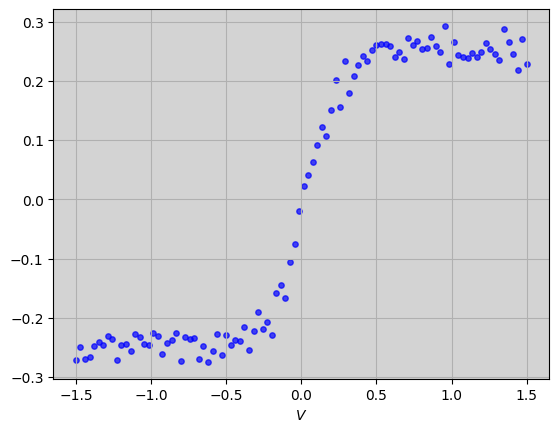

In [10]:
data = np.genfromtxt("iv_curve.csv", delimiter=",")
print(data.shape)

vs = np.linspace(-1.5, 1.5, len(data))

fig, ax = plt.subplots()

ax.set_facecolor("lightgrey")
ax.grid(True)
ax.set_xlabel("$V$")
ax.scatter(vs, data, s=15, alpha=.7, color="blue")

['input_idx', 'output_idx', 'control_voltages', 'inputs', 'outputs']


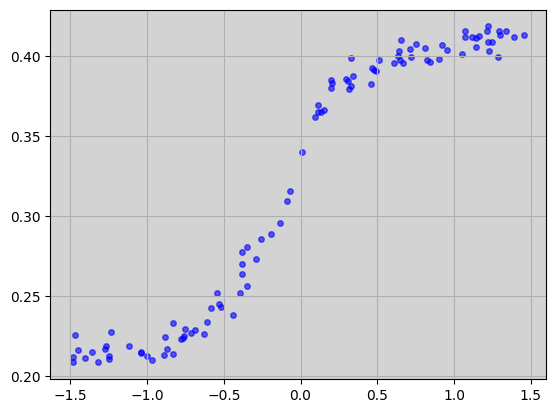

In [11]:
sweep_data = np.load("currentData/sweep_warmUp1e4_sim1e6_sig0.0_1.npz")
print(sweep_data.files)

in_idx = sweep_data["input_idx"]
out_idx = sweep_data["output_idx"]
control_voltages = sweep_data["control_voltages"]
inputs = sweep_data["inputs"]
outputs = sweep_data["outputs"]

plt.scatter(inputs, outputs, s=15.5, color="blue", alpha=.6)
ax = plt.gca()
ax.grid(True)
ax.set_facecolor("lightgrey")